# pc

> Point Cloud data manipulation

In [ ]:
#| default_exp cli/pc

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
import numpy as np
from matplotlib import pyplot as plt
from decorrelation.cli.utils.logging import get_logger

In [ ]:
#| export
import logging
import zarr
import numpy as np
import numexpr as ne
import time

import dask
from dask import array as da
from dask.distributed import Client, LocalCluster, progress

from decorrelation.pc import pc2ras, pc_hix, pc_sort, pc_union, pc_intersect, pc_diff
from decorrelation.cli.utils.logging import log_args, de_logger
from decorrelation.cli.utils.chunk_size import (get_pc_chunk_size_from_n_pc_chunk, 
                                                get_pc_chunk_size_from_pc_chunk_size, 
                                                get_pc_chunk_size_from_n_ras_chunk,
                                                get_ras_chunk_size_from_n_pc_chunk)

from fastcore.script import call_parse, Param

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_gix2bool(gix:str, # point cloud grid index
                is_pc:str, # output, output bool array
                shape:tuple, # shape of one image (nlines,width)
                az_chunk_size:int=None, # output azimuth chunk size, 
                n_az_chunk:int=None, # # output number of azimuth chunks
                r_chunk_size:int=None, # output range chunk size
                n_r_chunk:int=None, # output number of range chunks
):
    '''Convert pc grid index to bool 2d array'''
    logger = logging.getLogger(__name__)
    is_pc_path = is_pc

    gix_zarr = zarr.open(gix,mode='r')
    logger.zarr_info('gix',gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    logger.info('loading gix into memory.')
    gix = zarr.open(gix,mode='r')[:]

    logger.info('calculate the bool array')
    is_pc = np.zeros(shape,dtype=bool)
    is_pc[gix[0],gix[1]] = True

    chunks = get_ras_chunk_size_from_n_pc_chunk('gix','ras',gix_zarr.shape[1],gix_zarr.chunks[1],
                                               *shape,
                                               az_chunk_size=az_chunk_size,
                                               n_az_chunk=n_az_chunk,
                                               r_chunk_size=r_chunk_size,
                                               n_r_chunk=n_r_chunk,
                                              )
    is_pc_zarr = zarr.open(is_pc_path,'w',shape=shape,dtype=bool,chunks=chunks)
    logger.zarr_info('is_pc',is_pc_zarr)
    logger.info('write the bool array.')
    is_pc_zarr[:] = is_pc
    logger.info('write done.')

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_bool2gix(is_pc:str, # input bool array
                gix:str, # output, point cloud grid index
                pc_chunk_size:int=None, # output point chunk size
                n_pc_chunk:int=None, # output number of chunk
):
    '''Convert bool 2d array to grid index'''
    gix_path = gix
    logger = logging.getLogger(__name__)

    is_pc_zarr = zarr.open(is_pc,'r')
    logger.zarr_info('is_pc', is_pc_zarr)
    logger.info('loading is_pc into memory.')
    is_pc = zarr.open(is_pc,mode='r')[:]
    
    logger.info('calculate the index')
    gix = np.stack(np.where(is_pc))

    pc_chunk_size = get_pc_chunk_size_from_n_ras_chunk('is_pc','gix',
                                                       *is_pc_zarr.shape[:2],
                                                       *is_pc_zarr.chunks[:2],
                                                       gix.shape[1],
                                                       pc_chunk_size=pc_chunk_size, n_pc_chunk=n_pc_chunk)
    gix_zarr = zarr.open(gix_path,'w',shape=gix.shape,dtype=bool,chunks=(2,pc_chunk_size))
    logger.info('write the gix.')
    gix_zarr[:] = gix
    logger.info('write done.')

In [ ]:
#| export
@log_args
@de_logger
def de_ras2pc(gix:str, # point cloud grid index
              ras:str|list, # path (in string) or list of path for raster data
              pc:str|list, # output, path (in string) or list of path for point cloud data
              pc_chunk_size:int=None, # output point chunk size
              n_pc_chunk:int=None, # output number of chunk
):
    '''Convert raster data to point cloud data'''
    logger = logging.getLogger(__name__)

    gix_zarr = zarr.open(gix,mode='r')
    logger.zarr_info(gix,gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    pc_chunk_size = get_pc_chunk_size_from_pc_chunk_size('gix','pc',
                                                         gix_zarr.chunks[1],gix_zarr.shape[1],
                                                         pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)

    logger.info('loading gix into memory.')
    gix = zarr.open(gix,mode='r')[:]
    n_pc = gix.shape[1]

    if isinstance(ras,str):
        assert isinstance(pc,str)
        ras_list = [ras]; pc_list = [pc]
    else:
        assert isinstance(ras,list); assert isinstance(pc,list)
        ras_list = ras; pc_list = pc
        n_data = len(ras_list)

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        _pc_list = ()
        for ras_path, pc_path in zip(ras_list,pc_list):
            logger.info(f'start to slice on {ras_path}')
            ras_zarr = zarr.open(ras_path,'r'); logger.zarr_info(ras_path, ras_zarr)
            ras = da.from_zarr(ras_path,chunks=ras_zarr.chunks); logger.darr_info('ras',ras)
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                pc = ras.reshape(-1,*ras.shape[2:])[np.ravel_multi_index((gix[0],gix[1]),dims=ras.shape[:2])]
            logger.darr_info('pc', pc)
            logger.info('rechunk pc data:')
            pc = pc.rechunk((pc_chunk_size,*pc.chunksize[1:]))
            logger.darr_info('pc', pc)
            _pc = pc.to_zarr(pc_path,overwrite=True,compute=False)
            logger.info(f'saving to {pc_path}.')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
logger = get_logger()

In [ ]:
ras_data1 = np.random.rand(100,100).astype(np.float32)
ras_data2 = np.random.rand(100,100,3).astype(np.float32)+1j*np.random.rand(100,100,3).astype(np.float32)

gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100))).astype(np.int32)

pc_data1 = ras_data1[gix[0],gix[1]]
pc_data2 = ras_data2[gix[0],gix[1]]

gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(2,200))
ras_zarr1 = zarr.open('pc/ras1.zarr','w',shape=ras_data1.shape,dtype=ras_data1.dtype,chunks=(20,100))
ras_zarr2 = zarr.open('pc/ras2.zarr','w',shape=ras_data2.shape,dtype=ras_data2.dtype,chunks=(20,100,1))
gix_zarr[:] = gix
ras_zarr1[:] = ras_data1
ras_zarr2[:] = ras_data2

In [ ]:
de_ras2pc('pc/gix.zarr','pc/ras1.zarr','pc/pc1.zarr')
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])

de_ras2pc('pc/gix.zarr',ras=['pc/ras1.zarr','pc/ras2.zarr'],pc=['pc/pc1.zarr','pc/pc2.zarr'])
pc_zarr1 = zarr.open('pc/pc1.zarr','r')
pc_zarr2 = zarr.open('pc/pc2.zarr','r')
np.testing.assert_array_equal(pc_data1,pc_zarr1[:])
np.testing.assert_array_equal(pc_data2,pc_zarr2[:])

2024-04-22 01:29:57 - logging_args - INFO - running function: de_ras2pc
2024-04-22 01:29:57 - logging_args - INFO - fetching args:
2024-04-22 01:29:57 - logging_args - INFO - gix = 'pc/gix.zarr'
2024-04-22 01:29:57 - logging_args - INFO - ras = 'pc/ras1.zarr'
2024-04-22 01:29:57 - logging_args - INFO - pc = 'pc/pc1.zarr'
2024-04-22 01:29:57 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:29:57 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:29:57 - logging_args - INFO - fetching args done.
2024-04-22 01:29:57 - zarr_info - INFO - pc/gix.zarr zarray shape: (2, 1000)
2024-04-22 01:29:57 - zarr_info - INFO - pc/gix.zarr zarray chunks: (2, 200)
2024-04-22 01:29:57 - zarr_info - INFO - pc/gix.zarr zarray dtype: int32
2024-04-22 01:29:57 - get_pc_chunk_size_from_pc_chunk_size - INFO - automatically determine pc_chunk_size from
            pc_chunk_size of gix.
2024-04-22 01:29:57 - get_pc_chunk_size_from_pc_chunk_size - INFO - pc_chunk_size for pc: 200
2024-04-22 01:29:57 

In [ ]:
#| export
@log_args
@de_logger
def de_pc2ras(gix:str, # point cloud grid index
              pc:str|list, # path (in string) or list of path for point cloud data
              ras:str|list, # output, path (in string) or list of path for raster data
              shape:tuple, # shape of one image (nlines,width)
              az_chunk_size:int=None, # output azimuth chunk size, 
              n_az_chunk:int=None, # # output number of azimuth chunks
              r_chunk_size:int=None, # output range chunk size
              n_r_chunk:int=None, # output number of range chunks
):
    '''Convert point cloud data to raster data, filled with nan'''
    logger = logging.getLogger(__name__)

    gix_zarr = zarr.open(gix,mode='r')
    logger.zarr_info('gix', gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    chunk_size = get_ras_chunk_size_from_n_pc_chunk('gix','ras',
                                                    gix_zarr.shape[1],gix_zarr.chunks[1],
                                                    *shape,
                                                    az_chunk_size=az_chunk_size,n_az_chunk=n_az_chunk,
                                                    r_chunk_size=r_chunk_size,n_r_chunk=n_r_chunk
                                                    )
    logger.info('loading gix into memory.')
    gix = zarr.open(gix,mode='r')[:]
    n_pc = gix.shape[1]
    
    if isinstance(pc,str):
        assert isinstance(ras,str)
        pc_list = [pc]; ras_list = [ras]
    else:
        assert isinstance(pc,list); assert isinstance(ras,list)
        pc_list = pc; ras_list = ras

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _ras_list = ()

        for ras_path, pc_path in zip(ras_list,pc_list):
            logger.info(f'start to work on {pc_path}')
            pc_zarr = zarr.open(pc_path,'r')
            logger.zarr_info(pc_path,pc_zarr)

            pc = da.from_zarr(pc_path)
            logger.darr_info('pc', pc)
            ras = da.empty((shape[0]*shape[1],*pc.shape[1:]),chunks = (chunk_size[0]*shape[1],*pc_zarr.chunks[1:]), dtype=pc.dtype)
            ras[:] = np.nan
            ras[np.ravel_multi_index((gix[0],gix[1]),dims=shape)] = pc
            ras = ras.reshape(*shape,*pc.shape[1:])
            ras.rechunk((*chunk_size,*pc_zarr.chunks[1:]))
            logger.info('create ras dask array')
            logger.darr_info('ras', ras)
            _ras = ras.to_zarr(ras_path,overwrite=True,compute=False)
            _ras_list += (_ras,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_ras_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000).astype(np.float32)
pc_data2 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

gix = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix.sort()
gix = np.stack(np.unravel_index(gix,shape=(100,100))).astype(np.int32)

ras_data1 = np.zeros((100,100),dtype=np.float32)
ras_data2 = np.zeros((100,100,3),dtype=np.complex64)
ras_data1[:] = np.nan
ras_data2[:] = np.nan

ras_data1[gix[0],gix[1]] = pc_data1
ras_data2[gix[0],gix[1]] = pc_data2

gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(2,200))
pc_zarr1 = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,))
pc_zarr2 = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix_zarr[:] = gix
pc_zarr1[:] = pc_data1
pc_zarr2[:] = pc_data2

In [ ]:
de_pc2ras('pc/gix.zarr','pc/pc1.zarr','pc/ras1.zarr',shape=(100,100),az_chunk_size=20)
ras_zarr1 = zarr.open('pc/ras1.zarr','r')
np.testing.assert_array_equal(ras_data1,ras_zarr1[:])

de_pc2ras('pc/gix.zarr',['pc/pc1.zarr','pc/pc2.zarr'],['pc/ras1.zarr','pc/ras2.zarr'],shape=(100,100),az_chunk_size=20)
ras_zarr1 = zarr.open('pc/ras1.zarr','r')
ras_zarr2 = zarr.open('pc/ras2.zarr','r')
np.testing.assert_array_equal(ras_data1,ras_zarr1[:])
np.testing.assert_array_equal(ras_data2,ras_zarr2[:])

2024-04-22 01:30:11 - logging_args - INFO - running function: de_pc2ras
2024-04-22 01:30:11 - logging_args - INFO - fetching args:
2024-04-22 01:30:11 - logging_args - INFO - gix = 'pc/gix.zarr'
2024-04-22 01:30:11 - logging_args - INFO - pc = 'pc/pc1.zarr'
2024-04-22 01:30:11 - logging_args - INFO - ras = 'pc/ras1.zarr'
2024-04-22 01:30:11 - logging_args - INFO - shape = (100, 100)
2024-04-22 01:30:11 - logging_args - INFO - az_chunk_size = 20
2024-04-22 01:30:11 - logging_args - INFO - n_az_chunk = None
2024-04-22 01:30:11 - logging_args - INFO - r_chunk_size = None
2024-04-22 01:30:11 - logging_args - INFO - n_r_chunk = None
2024-04-22 01:30:11 - logging_args - INFO - fetching args done.
2024-04-22 01:30:11 - zarr_info - INFO - gix zarray shape: (2, 1000)
2024-04-22 01:30:11 - zarr_info - INFO - gix zarray chunks: (2, 200)
2024-04-22 01:30:11 - zarr_info - INFO - gix zarray dtype: int32
2024-04-22 01:30:11 - get_ras_chunk_size_from_n_pc_chunk - INFO - automatically set r_chunk_size 

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_hix(x:str, # horizonal coordinate
              y:str, # vertical coordinate
              hix:str, # output path
              bbox:list, # [x0, y0, xm, ym]
              interval:list # [x_interval, y_interval], cell size to make every cell has only one point falled in.
             ):
    '''Compute the hillbert index for point cloud data.'''
    logger = logging.getLogger(__name__)
    x_zarr = zarr.open(x,'r'); logger.zarr_info(x,x_zarr)
    y_zarr = zarr.open(y,'r'); logger.zarr_info(y,y_zarr)
    logger.info("calculating the hillbert index")
    hix_data = pc_hix(x_zarr[:],y_zarr[:],bbox,interval)
    hix_zarr = zarr.open(hix, 'w', chunks=x_zarr.chunks, dtype=hix_data.dtype, shape=hix_data.shape,)
    logger.info("writing the hillbert index")
    logger.zarr_info(hix, hix_zarr)
    hix_zarr[:] = hix_data
    logger.info("done.")

Usage:

In [ ]:
x = np.random.rand(1000)
y = np.random.rand(1000)
bbox = [0,0,1,1]
x_zarr = zarr.open('pc/x.zarr','w',shape=x.shape,dtype=x.dtype,chunks=(200,))
y_zarr = zarr.open('pc/y.zarr','w',shape=y.shape,dtype=y.dtype,chunks=(200,))
x_zarr[:] = x; y_zarr[:] = y

In [ ]:
de_pc_hix('pc/x.zarr', 'pc/y.zarr', 'pc/hix.zarr', bbox, interval=[0.00001,0.00001])

2024-04-22 01:30:18 - logging_args - INFO - running function: de_pc_hix
2024-04-22 01:30:18 - logging_args - INFO - fetching args:
2024-04-22 01:30:18 - logging_args - INFO - x = 'pc/x.zarr'
2024-04-22 01:30:18 - logging_args - INFO - y = 'pc/y.zarr'
2024-04-22 01:30:18 - logging_args - INFO - hix = 'pc/hix.zarr'
2024-04-22 01:30:18 - logging_args - INFO - bbox = [0, 0, 1, 1]
2024-04-22 01:30:18 - logging_args - INFO - interval = [1e-05, 1e-05]
2024-04-22 01:30:18 - logging_args - INFO - fetching args done.
2024-04-22 01:30:18 - zarr_info - INFO - pc/x.zarr zarray shape: (1000,)
2024-04-22 01:30:18 - zarr_info - INFO - pc/x.zarr zarray chunks: (200,)
2024-04-22 01:30:18 - zarr_info - INFO - pc/x.zarr zarray dtype: float64
2024-04-22 01:30:18 - zarr_info - INFO - pc/y.zarr zarray shape: (1000,)
2024-04-22 01:30:18 - zarr_info - INFO - pc/y.zarr zarray chunks: (200,)
2024-04-22 01:30:18 - zarr_info - INFO - pc/y.zarr zarray dtype: float64
2024-04-22 01:30:18 - de_pc_hix - INFO - calculat

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2024-04-22 01:30:20 - de_pc_hix - INFO - writing the hillbert index
2024-04-22 01:30:20 - zarr_info - INFO - pc/hix.zarr zarray shape: (1000,)
2024-04-22 01:30:20 - zarr_info - INFO - pc/hix.zarr zarray chunks: (200,)
2024-04-22 01:30:20 - zarr_info - INFO - pc/hix.zarr zarray dtype: int64
2024-04-22 01:30:20 - de_pc_hix - INFO - done.


<matplotlib.colorbar.Colorbar>

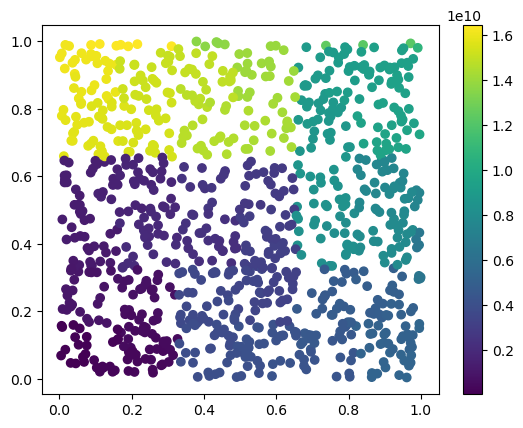

In [ ]:
hix = zarr.open('pc/hix.zarr','r')[:]
plt.scatter(x, y, c=hix)
plt.colorbar()

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_sort(idx_in:str, # the unsorted grid index or hillbert index of the input data
               idx:str, # output, the sorted grid index or hillbert index
               pc_in:str|list, # path (in string) or list of path for the input point cloud data
               pc:str|list, # output, path (in string) or list of path for the output point cloud data
               pc_chunk_size:int=None, # chunk size in output data,optional
              ):
    '''Sort point cloud data according to the indices that sort `idx_in`.
    '''
    idx_in_path = idx_in
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in_path,mode='r'); logger.zarr_info(idx_in_path,idx_in_zarr)
    logger.info('loading idx_in and calculate the sorting indices.')
    idx_in = idx_in_zarr[:]; iidx = pc_sort(idx_in)
    n_pc = idx_in_zarr.shape[-1]
    if pc_chunk_size is None: pc_chunk_size = idx_in_zarr.chunks[-1] 
    logger.info(f'output pc_chunk_size is {pc_chunk_size}')
    idx_chunk_size = (2, pc_chunk_size) if idx_in.ndim == 2 else (pc_chunk_size,)
    idx_zarr = zarr.open(idx,'w', shape=idx_in_zarr.shape, dtype=idx_in.dtype, chunks=idx_chunk_size)
    logger.info('write idx'); logger.zarr_info('idx', idx_zarr)
    idx_zarr[:] = idx_in[...,iidx]

    if isinstance(pc_in,str):
        assert isinstance(pc,str)
        pc_in_list = [pc_in]; pc_list = [pc]
    else:
        assert isinstance(pc_in,list); assert isinstance(pc,list)
        pc_in_list = pc_in; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc_in_path, pc_path in zip(pc_in_list,pc_list):
            pc_in_zarr = zarr.open(pc_in_path,'r'); logger.zarr_info(pc_in_path, pc_in_zarr)
            pc_in = da.from_zarr(pc_in_zarr,chunks=(n_pc,*pc_in_zarr.chunks[1:]))
            logger.darr_info('pc_in', pc_in)
            logger.info('set up sorted pc data dask array.')
            pc = da.empty(pc_in.shape,chunks = pc_in.chunks, dtype=pc_in.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc_in[iidx]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((pc_chunk_size,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            # _pc.visualize(filename=f'_pc.svg')
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100))).astype(np.int32)
ind = np.lexsort((gix_in[1],gix_in[0]))
pc = pc_in[ind]; gix = gix_in[:,ind]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(2,100))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in

In [ ]:
de_pc_sort('pc/gix_in.zarr','pc/gix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r'); gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)
np.testing.assert_array_equal(gix_zarr[:],gix)

2024-04-22 01:30:29 - logging_args - INFO - running function: de_pc_sort
2024-04-22 01:30:29 - logging_args - INFO - fetching args:
2024-04-22 01:30:29 - logging_args - INFO - idx_in = 'pc/gix_in.zarr'
2024-04-22 01:30:29 - logging_args - INFO - idx = 'pc/gix.zarr'
2024-04-22 01:30:29 - logging_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-04-22 01:30:29 - logging_args - INFO - pc = 'pc/pc.zarr'
2024-04-22 01:30:29 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:30:29 - logging_args - INFO - fetching args done.
2024-04-22 01:30:29 - zarr_info - INFO - pc/gix_in.zarr zarray shape: (2, 1000)
2024-04-22 01:30:29 - zarr_info - INFO - pc/gix_in.zarr zarray chunks: (2, 100)
2024-04-22 01:30:29 - zarr_info - INFO - pc/gix_in.zarr zarray dtype: int32
2024-04-22 01:30:29 - de_pc_sort - INFO - loading idx_in and calculate the sorting indices.
2024-04-22 01:30:29 - de_pc_sort - INFO - output pc_chunk_size is 100
2024-04-22 01:30:29 - de_pc_sort - INFO - write idx
2024-04-22 01:30:29 - zar

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
ind = np.argsort(hix_in,kind='stable')
pc = pc_in[ind]; hix = hix_in[ind]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in

de_pc_sort('pc/hix_in.zarr','pc/hix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r'); hix_zarr = zarr.open('pc/hix.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)
np.testing.assert_array_equal(hix_zarr[:],hix)

2024-04-22 01:30:32 - logging_args - INFO - running function: de_pc_sort
2024-04-22 01:30:32 - logging_args - INFO - fetching args:
2024-04-22 01:30:32 - logging_args - INFO - idx_in = 'pc/hix_in.zarr'
2024-04-22 01:30:32 - logging_args - INFO - idx = 'pc/hix.zarr'
2024-04-22 01:30:32 - logging_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-04-22 01:30:32 - logging_args - INFO - pc = 'pc/pc.zarr'
2024-04-22 01:30:32 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:30:32 - logging_args - INFO - fetching args done.
2024-04-22 01:30:32 - zarr_info - INFO - pc/hix_in.zarr zarray shape: (1000,)
2024-04-22 01:30:32 - zarr_info - INFO - pc/hix_in.zarr zarray chunks: (100,)
2024-04-22 01:30:32 - zarr_info - INFO - pc/hix_in.zarr zarray dtype: int64
2024-04-22 01:30:32 - de_pc_sort - INFO - loading idx_in and calculate the sorting indices.
2024-04-22 01:30:32 - de_pc_sort - INFO - output pc_chunk_size is 100
2024-04-22 01:30:32 - de_pc_sort - INFO - write idx
2024-04-22 01:30:32 - zarr_in

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_union(idx1:str, # grid index or hillbert index of the first point cloud
                idx2:str, # grid index or hillbert index of the second point cloud
                idx:str, # output, grid index or hillbert index of the union point cloud
                pc1:str|list=None, # path (in string) or list of path for the first point cloud data
                pc2:str|list=None, # path (in string) or list of path for the second point cloud data
                pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
                pc_chunk_size:int=None, # chunk size in output data,optional
                n_pc_chunk:int=None, # number of chunk in output data, optional
):
    '''Get the union of two point cloud dataset.
    For points at their intersection, pc_data1 rather than pc_data2 is copied to the result pc_data.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the pc_chunk_size is setted as it in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the union')
    idx_path = idx
    idx, inv_iidx1, inv_iidx2, iidx2 = pc_union(idx1,idx2)
    n_pc = idx.shape[-1]
    logger.info(f'number of points in the union: {n_pc}')
    pc_chunk_size = get_pc_chunk_size_from_pc_chunk_size('idx1','idx',
                                                         idx1_zarr.chunks[-1],
                                                         n_pc,
                                                         pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)
    idx_chunk_size = (2, pc_chunk_size) if idx.ndim == 2 else (pc_chunk_size,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write union idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)
    
    if pc1 is None:
        logger.info('no point cloud data provided, exit.')
        return None

    if isinstance(pc1,str):
        assert isinstance(pc2,str); assert isinstance(pc,str)
        pc1_list = [pc1]; pc2_list = [pc2]; pc_list = [pc]
    else:
        assert isinstance(pc1,list); assert isinstance(pc2,list); assert isinstance(pc,list)
        pc1_list = pc1; pc2_list = pc2; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, n_workers=1, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc1_path, pc2_path, pc_path in zip(pc1_list,pc2_list,pc_list):
            pc1_zarr = zarr.open(pc1_path,'r'); pc2_zarr = zarr.open(pc2_path,'r')
            logger.zarr_info(pc1_path, pc1_zarr); logger.zarr_info(pc2_path, pc2_zarr);
            pc1 = da.from_zarr(pc1_path,chunks=(pc1_zarr.shape[0],*pc1_zarr.chunks[1:]))
            pc2 = da.from_zarr(pc2_path,chunks=(pc2_zarr.shape[0],*pc2_zarr.chunks[1:]))
            logger.darr_info('pc1', pc1); logger.darr_info('pc2',pc2)
            logger.info('set up union pc data dask array.')
            pc = da.empty((n_pc,*pc1.shape[1:]),chunks = (n_pc,*pc1.chunks[1:]), dtype=pc1.dtype)
            logger.darr_info('pc',pc)
            pc[inv_iidx1] = pc1
            pc[inv_iidx2] = pc2[iidx2]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((pc_chunk_size,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg')
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')

    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100))).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100))).astype(np.int32)

gix, inv_iidx1, inv_iidx2, iidx2 = pc_union(gix1,gix2)

pc_data = np.empty((gix.shape[1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(2,200))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(2,200))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
de_pc_union('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr')
de_pc_union('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr','pc/pc1.zarr','pc/pc2.zarr','pc/pc.zarr')
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-04-22 01:30:55 - logging_args - INFO - running function: de_pc_union
2024-04-22 01:30:55 - logging_args - INFO - fetching args:
2024-04-22 01:30:55 - logging_args - INFO - idx1 = 'pc/gix1.zarr'
2024-04-22 01:30:55 - logging_args - INFO - idx2 = 'pc/gix2.zarr'
2024-04-22 01:30:55 - logging_args - INFO - idx = 'pc/gix.zarr'
2024-04-22 01:30:55 - logging_args - INFO - pc1 = None
2024-04-22 01:30:55 - logging_args - INFO - pc2 = None
2024-04-22 01:30:55 - logging_args - INFO - pc = None
2024-04-22 01:30:55 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:30:55 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:30:55 - logging_args - INFO - fetching args done.
2024-04-22 01:30:55 - zarr_info - INFO - pc/gix1.zarr zarray shape: (2, 1000)
2024-04-22 01:30:55 - zarr_info - INFO - pc/gix1.zarr zarray chunks: (2, 200)
2024-04-22 01:30:55 - zarr_info - INFO - pc/gix1.zarr zarray dtype: int32
2024-04-22 01:30:55 - zarr_info - INFO - pc/gix2.zarr zarray shape: (2, 800)
2024-04-2

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, inv_iidx1, inv_iidx2, iidx2 = pc_union(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[inv_iidx1] = pc_data1
pc_data[inv_iidx2] = pc_data2[iidx2]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
de_pc_union('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
de_pc_union('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr','pc/pc1.zarr','pc/pc2.zarr','pc/pc.zarr')
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-04-22 01:31:00 - logging_args - INFO - running function: de_pc_union
2024-04-22 01:31:00 - logging_args - INFO - fetching args:
2024-04-22 01:31:00 - logging_args - INFO - idx1 = 'pc/hix1.zarr'
2024-04-22 01:31:00 - logging_args - INFO - idx2 = 'pc/hix2.zarr'
2024-04-22 01:31:00 - logging_args - INFO - idx = 'pc/hix.zarr'
2024-04-22 01:31:00 - logging_args - INFO - pc1 = None
2024-04-22 01:31:00 - logging_args - INFO - pc2 = None
2024-04-22 01:31:00 - logging_args - INFO - pc = None
2024-04-22 01:31:00 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:00 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:00 - logging_args - INFO - fetching args done.
2024-04-22 01:31:00 - zarr_info - INFO - pc/hix1.zarr zarray shape: (1000,)
2024-04-22 01:31:00 - zarr_info - INFO - pc/hix1.zarr zarray chunks: (200,)
2024-04-22 01:31:00 - zarr_info - INFO - pc/hix1.zarr zarray dtype: int64
2024-04-22 01:31:00 - zarr_info - INFO - pc/hix2.zarr zarray shape: (800,)
2024-04-22 01:3

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_intersect(idx1:str, # grid index or hillbert index of the first point cloud
                    idx2:str, # grid index or hillbert index of the second point cloud
                    idx:str, # output, grid index or hillbert index of the union point cloud
                    pc1:str|list=None, # path (in string) or list of path for the first point cloud data
                    pc2:str|list=None, # path (in string) or list of path for the second point cloud data
                    pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
                    pc_chunk_size:int=None, # chunk size in output data,optional
                    n_pc_chunk:int=None, # number of chunk in output data, optional
                    prefer_1=True, # save pc1 on intersection to output pc dataset by default `True`. Otherwise, save data from pc2
):
    '''Get the intersection of two point cloud dataset.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the n_pc_chunk is set to n_chunk in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the intersection')
    idx_path = idx
    idx, iidx1, iidx2 = pc_intersect(idx1,idx2)
    n_pc = idx.shape[-1]
    logger.info(f'number of points in the intersection: {n_pc}')
    pc_chunk_size = get_pc_chunk_size_from_n_pc_chunk('idx1','idx',idx1_zarr.shape[-1],idx1_zarr.chunks[-1],n_pc,pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)
    
    idx_chunk_size = (2, pc_chunk_size) if idx.ndim == 2 else (pc_chunk_size,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write intersect idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)

    if (pc1 is None) and (pc2 is None):
        logger.info('no point cloud data provided, exit.')
        return None

    if prefer_1:
        logger.info('select pc1 as pc_input.')
        iidx = iidx1; pc_input = pc1
    else:
        logger.info('select pc2 as pc_input.')
        iidx = iidx2; pc_input = pc2

    if isinstance(pc_input,str):
        assert isinstance(pc,str)
        pc_input_list = [pc_input]; pc_list = [pc]
    else:
        assert isinstance(pc_input,list); assert isinstance(pc,list)
        pc_input_list = pc_input; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc_input_path, pc_path in zip(pc_input_list,pc_list):
            pc_input_zarr = zarr.open(pc_input_path,'r')
            logger.zarr_info(pc_input_path,pc_input_zarr)
            pc_input = da.from_zarr(pc_input_path)
            logger.darr_info('pc_input', pc_input)

            logger.info('set up intersect pc data dask array.')
            pc = da.empty((n_pc,*pc_input.shape[1:]),chunks = (n_pc,*pc_input.chunks[1:]), dtype=pc_input.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc_input[iidx]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((pc_chunk_size,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg')
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100))).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100))).astype(np.int32)

gix, iidx1, iidx2 = pc_intersect(gix1,gix2)

pc_data = np.empty((gix.shape[1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data2[iidx2]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(2,200))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(2,200))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
de_pc_intersect('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr')
de_pc_intersect('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr',pc2='pc/pc2.zarr', pc='pc/pc.zarr',prefer_1=False)
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-04-22 01:31:11 - logging_args - INFO - running function: de_pc_intersect
2024-04-22 01:31:11 - logging_args - INFO - fetching args:
2024-04-22 01:31:11 - logging_args - INFO - idx1 = 'pc/gix1.zarr'
2024-04-22 01:31:11 - logging_args - INFO - idx2 = 'pc/gix2.zarr'
2024-04-22 01:31:11 - logging_args - INFO - idx = 'pc/gix.zarr'
2024-04-22 01:31:11 - logging_args - INFO - pc1 = None
2024-04-22 01:31:11 - logging_args - INFO - pc2 = None
2024-04-22 01:31:11 - logging_args - INFO - pc = None
2024-04-22 01:31:11 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:11 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:11 - logging_args - INFO - prefer_1 = True
2024-04-22 01:31:11 - logging_args - INFO - fetching args done.
2024-04-22 01:31:11 - zarr_info - INFO - pc/gix1.zarr zarray shape: (2, 1000)
2024-04-22 01:31:11 - zarr_info - INFO - pc/gix1.zarr zarray chunks: (2, 200)
2024-04-22 01:31:11 - zarr_info - INFO - pc/gix1.zarr zarray dtype: int32
2024-04-22 01:31:11 - 

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)
pc_data2 = np.random.rand(800,3).astype(np.float32)+1j*np.random.rand(800,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, iidx1, iidx2 = pc_intersect(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data2[iidx2]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
pc2_zarr = zarr.open('pc/pc2.zarr','w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1
pc2_zarr[:] = pc_data2

In [ ]:
de_pc_intersect('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
de_pc_intersect('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr',pc2='pc/pc2.zarr', pc='pc/pc.zarr',prefer_1=False)
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-04-22 01:31:15 - logging_args - INFO - running function: de_pc_intersect
2024-04-22 01:31:15 - logging_args - INFO - fetching args:
2024-04-22 01:31:15 - logging_args - INFO - idx1 = 'pc/hix1.zarr'
2024-04-22 01:31:15 - logging_args - INFO - idx2 = 'pc/hix2.zarr'
2024-04-22 01:31:15 - logging_args - INFO - idx = 'pc/hix.zarr'
2024-04-22 01:31:15 - logging_args - INFO - pc1 = None
2024-04-22 01:31:15 - logging_args - INFO - pc2 = None
2024-04-22 01:31:15 - logging_args - INFO - pc = None
2024-04-22 01:31:15 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:15 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:15 - logging_args - INFO - prefer_1 = True
2024-04-22 01:31:15 - logging_args - INFO - fetching args done.
2024-04-22 01:31:15 - zarr_info - INFO - pc/hix1.zarr zarray shape: (1000,)
2024-04-22 01:31:15 - zarr_info - INFO - pc/hix1.zarr zarray chunks: (200,)
2024-04-22 01:31:15 - zarr_info - INFO - pc/hix1.zarr zarray dtype: int64
2024-04-22 01:31:15 - zarr

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_diff(idx1:str, # grid index or hillbert index of the first point cloud
               idx2:str, # grid index or hillbert index of the second point cloud
               idx:str, # output, grid index or hillbert index of the union point cloud
               pc1:str|list=None, # path (in string) or list of path for the first point cloud data
               pc:str|list=None, #output, path (in string) or list of path for the union point cloud data
               pc_chunk_size:int=None, # chunk size in output data,optional
               n_pc_chunk:int=None, # number of chunk in output data, optional
              ):
    '''Get the point cloud in `idx1` that are not in `idx2`.
    `pc_chunk_size` and `n_pc_chunk` are used to determine the final pc_chunk_size.
    If non of them are provided, the n_pc_chunk is set to n_chunk in idx1.
    '''
    logger = logging.getLogger(__name__)

    idx1_zarr = zarr.open(idx1,mode='r'); logger.zarr_info(idx1,idx1_zarr)
    idx2_zarr = zarr.open(idx2,mode='r'); logger.zarr_info(idx2,idx2_zarr)
    logger.info('loading idx1 and idx2 into memory.')
    idx1 = idx1_zarr[:]; idx2 = idx2_zarr[:]

    logger.info('calculate the diff.')
    idx_path = idx
    idx, iidx1 = pc_diff(idx1,idx2)
    n_pc = idx.shape[-1]
    logger.info(f'number of points in the diff: {n_pc}')
    pc_chunk_size = get_pc_chunk_size_from_n_pc_chunk('idx1','idx',idx1_zarr.shape[-1],idx1_zarr.chunks[-1],n_pc,pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)

    idx_chunk_size = (2, pc_chunk_size) if idx.ndim == 2 else (pc_chunk_size,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.info('write intersect idx')
    idx_zarr[:] = idx
    logger.info('write done')
    logger.zarr_info(idx_path, idx_zarr)

    if pc1 is None:
        logger.info('no point cloud data provided, exit.')
        return None

    if isinstance(pc1,str):
        assert isinstance(pc,str)
        pc1_list = [pc1]; pc_list = [pc]
    else:
        assert isinstance(pc1,list); assert isinstance(pc,list)
        pc1_list = pc1; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc1_path, pc_path in zip(pc1_list,pc_list):
            pc1_zarr = zarr.open(pc1_path,'r'); logger.zarr_info(pc1_path, pc1_zarr)
            pc1 = da.from_zarr(pc1_path); logger.darr_info('pc1', pc1)
            logger.info('set up diff pc data dask array.')
            pc = da.empty((n_pc,*pc1.shape[1:]),chunks = (n_pc,*pc1.chunks[1:]), dtype=pc1.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc1[iidx1]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((pc_chunk_size,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg',optimize_graph=True)
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

Usage:

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

gix1 = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix1.sort()
gix1 = np.stack(np.unravel_index(gix1,shape=(100,100))).astype(np.int32)

gix2 = np.random.choice(np.arange(100*100,dtype=np.int32),size=800,replace=False)
gix2.sort()
gix2 = np.stack(np.unravel_index(gix2,shape=(100,100))).astype(np.int32)

gix, iidx1 = pc_diff(gix1,gix2)

pc_data = np.empty((gix.shape[1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data1[iidx1]

gix1_zarr = zarr.open('pc/gix1.zarr','w',shape=gix1.shape,dtype=gix1.dtype,chunks=(2,200))
gix2_zarr = zarr.open('pc/gix2.zarr','w',shape=gix2.shape,dtype=gix2.dtype,chunks=(2,200))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
gix1_zarr[:] = gix1
gix2_zarr[:] = gix2
pc1_zarr[:] = pc_data1

In [ ]:
de_pc_diff('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr')
de_pc_diff('pc/gix1.zarr','pc/gix2.zarr','pc/gix.zarr',pc1='pc/pc1.zarr', pc='pc/pc.zarr')
gix_zarr = zarr.open('pc/gix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-04-22 01:31:23 - logging_args - INFO - running function: de_pc_diff
2024-04-22 01:31:23 - logging_args - INFO - fetching args:
2024-04-22 01:31:23 - logging_args - INFO - idx1 = 'pc/gix1.zarr'
2024-04-22 01:31:23 - logging_args - INFO - idx2 = 'pc/gix2.zarr'
2024-04-22 01:31:23 - logging_args - INFO - idx = 'pc/gix.zarr'
2024-04-22 01:31:23 - logging_args - INFO - pc1 = None
2024-04-22 01:31:23 - logging_args - INFO - pc = None
2024-04-22 01:31:23 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:23 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:23 - logging_args - INFO - fetching args done.
2024-04-22 01:31:23 - zarr_info - INFO - pc/gix1.zarr zarray shape: (2, 1000)
2024-04-22 01:31:23 - zarr_info - INFO - pc/gix1.zarr zarray chunks: (2, 200)
2024-04-22 01:31:23 - zarr_info - INFO - pc/gix1.zarr zarray dtype: int32
2024-04-22 01:31:23 - zarr_info - INFO - pc/gix2.zarr zarray shape: (2, 800)
2024-04-22 01:31:23 - zarr_info - INFO - pc/gix2.zarr zarray chun

In [ ]:
pc_data1 = np.random.rand(1000,3).astype(np.float32)+1j*np.random.rand(1000,3).astype(np.float32)

hix1 = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix1.sort()

hix2 = np.random.choice(np.arange(100*100,dtype=np.int64),size=800,replace=False)
hix2.sort()

hix, iidx1 = pc_diff(hix1,hix2)

pc_data = np.empty((hix.shape[-1],*pc_data1.shape[1:]),dtype=pc_data1.dtype)
pc_data[:] = pc_data1[iidx1]

hix1_zarr = zarr.open('pc/hix1.zarr','w',shape=hix1.shape,dtype=hix1.dtype,chunks=(200,))
hix2_zarr = zarr.open('pc/hix2.zarr','w',shape=hix2.shape,dtype=hix2.dtype,chunks=(200,))
pc1_zarr = zarr.open('pc/pc1.zarr','w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(200,1))
hix1_zarr[:] = hix1
hix2_zarr[:] = hix2
pc1_zarr[:] = pc_data1

In [ ]:
de_pc_diff('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr')
de_pc_diff('pc/hix1.zarr','pc/hix2.zarr','pc/hix.zarr',pc1='pc/pc1.zarr', pc='pc/pc.zarr')
hix_zarr = zarr.open('pc/hix.zarr','r')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)
np.testing.assert_array_equal(pc_zarr[:],pc_data)

2024-04-22 01:31:28 - logging_args - INFO - running function: de_pc_diff
2024-04-22 01:31:28 - logging_args - INFO - fetching args:
2024-04-22 01:31:28 - logging_args - INFO - idx1 = 'pc/hix1.zarr'
2024-04-22 01:31:28 - logging_args - INFO - idx2 = 'pc/hix2.zarr'
2024-04-22 01:31:28 - logging_args - INFO - idx = 'pc/hix.zarr'
2024-04-22 01:31:28 - logging_args - INFO - pc1 = None
2024-04-22 01:31:28 - logging_args - INFO - pc = None
2024-04-22 01:31:28 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:28 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:28 - logging_args - INFO - fetching args done.
2024-04-22 01:31:28 - zarr_info - INFO - pc/hix1.zarr zarray shape: (1000,)
2024-04-22 01:31:28 - zarr_info - INFO - pc/hix1.zarr zarray chunks: (200,)
2024-04-22 01:31:28 - zarr_info - INFO - pc/hix1.zarr zarray dtype: int64
2024-04-22 01:31:28 - zarr_info - INFO - pc/hix2.zarr zarray shape: (800,)
2024-04-22 01:31:28 - zarr_info - INFO - pc/hix2.zarr zarray chunks: (2

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_logic_ras(ras, # the raster image used for thresholding
                    gix, # output, grid index of selected pixels
                    operation:str, # logical operation on input ras
                    pc_chunk_size:int=None, # chunk size in output data,optional
                    n_pc_chunk:int=None, # number of chunk in output data, optional
                   ):
    '''generate point cloud index based on logical operation of one raster image.
    '''
    gix_path = gix
    logger = logging.getLogger(__name__)
    ras_zarr = zarr.open(ras, mode='r'); logger.zarr_info(ras,ras_zarr)

    ras = ras_zarr[:]; logger.info('loading ras into memory.')
    is_pc = ne.evaluate(operation,{'ras':ras})
    logger.info(f'select pc based on operation: {operation}')
    gix = np.stack(np.where(is_pc)).astype(np.int32)
    n_pc = gix.shape[1]
    logger.info(f'number of selected pixels: {n_pc}.')
    pc_chunk_size = get_pc_chunk_size_from_n_ras_chunk('ras','gix',
                                                       *ras_zarr.shape[:2],
                                                       *ras_zarr.chunks[:2],
                                                       n_pc,pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)
    gix_zarr = zarr.open(gix_path,'w',dtype=gix.dtype,shape=gix.shape,chunks=(2,pc_chunk_size))
    logger.info('writing gix.')
    gix_zarr[:] = gix
    logger.info('write done.')

In [ ]:
ras = np.random.rand(100,100).astype(np.float32)
min_thres = 0.1; max_thres=0.5
is_pc = (ras>=min_thres) & (ras<=max_thres)
gix = np.stack(np.where(is_pc)).astype(np.int32)
ras_zarr = zarr.open('pc/ras.zarr','rw',shape=ras.shape,dtype=ras.dtype,chunks=(10,100))
ras_zarr[:] = ras

In [ ]:
de_pc_logic_ras('pc/ras.zarr','pc/gix.zarr',f'(ras>={min_thres})&(ras<={max_thres})')
gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)

2024-04-22 01:31:33 - logging_args - INFO - running function: de_pc_logic_ras
2024-04-22 01:31:33 - logging_args - INFO - fetching args:
2024-04-22 01:31:33 - logging_args - INFO - ras = 'pc/ras.zarr'
2024-04-22 01:31:33 - logging_args - INFO - gix = 'pc/gix.zarr'
2024-04-22 01:31:33 - logging_args - INFO - operation = '(ras>=0.1)&(ras<=0.5)'
2024-04-22 01:31:33 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:33 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:33 - logging_args - INFO - fetching args done.
2024-04-22 01:31:33 - zarr_info - INFO - pc/ras.zarr zarray shape: (100, 100)
2024-04-22 01:31:33 - zarr_info - INFO - pc/ras.zarr zarray chunks: (10, 100)
2024-04-22 01:31:33 - zarr_info - INFO - pc/ras.zarr zarray dtype: float32
2024-04-22 01:31:33 - de_pc_logic_ras - INFO - loading ras into memory.
2024-04-22 01:31:33 - de_pc_logic_ras - INFO - select pc based on operation: (ras>=0.1)&(ras<=0.5)
2024-04-22 01:31:33 - de_pc_logic_ras - INFO - number of selec

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_logic_pc(idx_in:str,# the grid index or hillbert index of input pc data
                   pc_in:str, # the grid index or hillbert index cloud data used for thresholding
                   idx:str, # output, grid index or hillbert index of selected pixels
                   operation:str, # operator
                   pc_chunk_size:int=None, # chunk size in output data,optional
                   n_pc_chunk:int=None, # number of chunk in output data, optional
                   ):
    '''generate point cloud index and data based on logical operation one point cloud data.
    '''
    idx_path = idx
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in,mode='r'); logger.zarr_info(idx_in,idx_in_zarr)
    pc_in_zarr = zarr.open(pc_in, mode='r'); logger.zarr_info(pc_in,pc_in_zarr)

    idx_in = idx_in_zarr[:]; logger.info('loading idx_in into memory.')
    pc_in = pc_in_zarr[:]; logger.info('loading pc_in into memory.')

    is_pc = ne.evaluate(operation,{'pc_in':pc_in})
    logger.info(f'select pc based on operation: {operation}')
    idx = idx_in[...,is_pc]
    n_pc = idx.shape[-1]
    logger.info(f'number of selected pixels: {n_pc}.')
    pc_chunk_size = get_pc_chunk_size_from_n_pc_chunk('idx_in','idx',idx_in_zarr.shape[-1],idx_in_zarr.chunks[-1],n_pc, pc_chunk_size=pc_chunk_size, n_pc_chunk= n_pc_chunk)
    idx_chunk_size = (2, pc_chunk_size) if idx.ndim == 2 else (pc_chunk_size,)
    idx_zarr = zarr.open(idx_path,'w',shape=idx.shape,dtype=idx.dtype,chunks=idx_chunk_size)
    logger.zarr_info('idx', idx_zarr)
    logger.info('writing idx.')
    idx_zarr[:] = idx
    logger.info('write done.')

Usage:

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in.sort()
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100))).astype(np.int32)

min_thres = 0.1; max_thres=0.5
is_pc = (pc_in>=min_thres) & (pc_in<=max_thres)
gix = gix_in[...,is_pc]
pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(2,100))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in

In [ ]:
de_pc_logic_pc('pc/gix_in.zarr','pc/pc_in.zarr','pc/gix.zarr',f'(pc_in>={min_thres})&(pc_in<={max_thres})')
gix_zarr = zarr.open('pc/gix.zarr','r')
np.testing.assert_array_equal(gix_zarr[:],gix)

2024-04-22 01:31:39 - logging_args - INFO - running function: de_pc_logic_pc
2024-04-22 01:31:39 - logging_args - INFO - fetching args:
2024-04-22 01:31:39 - logging_args - INFO - idx_in = 'pc/gix_in.zarr'
2024-04-22 01:31:39 - logging_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-04-22 01:31:39 - logging_args - INFO - idx = 'pc/gix.zarr'
2024-04-22 01:31:39 - logging_args - INFO - operation = '(pc_in>=0.1)&(pc_in<=0.5)'
2024-04-22 01:31:39 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:39 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:39 - logging_args - INFO - fetching args done.
2024-04-22 01:31:39 - zarr_info - INFO - pc/gix_in.zarr zarray shape: (2, 1000)
2024-04-22 01:31:39 - zarr_info - INFO - pc/gix_in.zarr zarray chunks: (2, 100)
2024-04-22 01:31:39 - zarr_info - INFO - pc/gix_in.zarr zarray dtype: int32
2024-04-22 01:31:39 - zarr_info - INFO - pc/pc_in.zarr zarray shape: (1000,)
2024-04-22 01:31:39 - zarr_info - INFO - pc/pc_in.zarr zarray chunks: (100

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix_in.sort()

min_thres = 0.1; max_thres=0.5
is_pc = (pc_in>=min_thres) & (pc_in<=max_thres)
hix = hix_in[...,is_pc]
pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in

de_pc_logic_pc('pc/hix_in.zarr','pc/pc_in.zarr','pc/hix.zarr',f'(pc_in>={min_thres})&(pc_in<={max_thres})')
hix_zarr = zarr.open('pc/hix.zarr','r')
np.testing.assert_array_equal(hix_zarr[:],hix)

2024-04-22 01:31:40 - logging_args - INFO - running function: de_pc_logic_pc
2024-04-22 01:31:40 - logging_args - INFO - fetching args:
2024-04-22 01:31:40 - logging_args - INFO - idx_in = 'pc/hix_in.zarr'
2024-04-22 01:31:40 - logging_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-04-22 01:31:40 - logging_args - INFO - idx = 'pc/hix.zarr'
2024-04-22 01:31:40 - logging_args - INFO - operation = '(pc_in>=0.1)&(pc_in<=0.5)'
2024-04-22 01:31:40 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:40 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:40 - logging_args - INFO - fetching args done.
2024-04-22 01:31:40 - zarr_info - INFO - pc/hix_in.zarr zarray shape: (1000,)
2024-04-22 01:31:40 - zarr_info - INFO - pc/hix_in.zarr zarray chunks: (100,)
2024-04-22 01:31:40 - zarr_info - INFO - pc/hix_in.zarr zarray dtype: int64
2024-04-22 01:31:40 - zarr_info - INFO - pc/pc_in.zarr zarray shape: (1000,)
2024-04-22 01:31:40 - zarr_info - INFO - pc/pc_in.zarr zarray chunks: (100,)
2

In [ ]:
#| export
@call_parse
@log_args
@de_logger
def de_pc_select_data(idx_in:str, # the grid index or hillbert index of the input data
                      idx:str, # the grid index or hillbert index of the output data
                      pc_in:str|list, # path (in string) or list of path for the input point cloud data
                      pc:str|list, # output, path (in string) or list of path for the output point cloud data
                      pc_chunk_size:int=None, # chunk size in output data,optional
                      n_pc_chunk:int=None, # number of chunk in output data, optional
                     ):
    '''generate point cloud data based on its index and one point cloud data.
    The index of generated point cloud data must in the index of the old one.
    '''
    idx_in_path = idx_in; idx_path = idx
    logger = logging.getLogger(__name__)
    idx_in_zarr = zarr.open(idx_in_path,mode='r'); logger.zarr_info(idx_in_path,idx_in_zarr)
    idx_zarr = zarr.open(idx_path,mode='r'); logger.zarr_info(idx_path,idx_zarr)
    logger.info('loading idx_in and idx into memory.')
    idx_in = idx_in_zarr[:]; idx = idx_zarr[:]
    iidx_in, iidx = pc_intersect(idx_in,idx)[1:]
    np.testing.assert_array_equal(iidx,np.arange(iidx.shape[0]),err_msg='idx have points that are not covered by idx_in.')
    n_pc = iidx_in.shape[0]
    pc_chunk_size = get_pc_chunk_size_from_pc_chunk_size('idx','pc',idx_zarr.chunks[-1],n_pc,pc_chunk_size=pc_chunk_size,n_pc_chunk=n_pc_chunk)

    if isinstance(pc_in,str):
        assert isinstance(pc,str)
        pc_in_list = [pc_in]; pc_list = [pc]
    else:
        assert isinstance(pc_in,list); assert isinstance(pc,list)
        pc_in_list = pc_in; pc_list = pc

    logger.info('starting dask local cluster.')
    with LocalCluster(processes=False, threads_per_worker=2) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')

        _pc_list = ()
        for pc_in_path, pc_path in zip(pc_in_list,pc_list):
            pc_in_zarr = zarr.open(pc_in_path,'r'); logger.zarr_info(pc_in_path, pc_in_zarr)
            pc_in = da.from_zarr(pc_in_path); logger.darr_info('pc_in', pc_in)
            logger.info('set up selected pc data dask array.')
            pc = da.empty((n_pc,*pc_in.shape[1:]),chunks = (n_pc,*pc_in.chunks[1:]), dtype=pc_in.dtype)
            logger.darr_info('pc',pc)
            pc[:] = pc_in[iidx_in]
            logger.info('rechunk dask array for writing.')
            pc = pc.rechunk((pc_chunk_size,*pc.chunks[1:]))
            logger.darr_info('pc',pc)
            logger.info('write')
            # pc.visualize(filename=f'pc.svg',optimize_graph=True)
            _pc = pc.to_zarr(pc_path, overwrite=True,compute=False)
            _pc_list += (_pc,)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_pc_list)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
gix_in = np.random.choice(np.arange(100*100,dtype=np.int32),size=1000,replace=False)
gix_in.sort()
gix_in = np.stack(np.unravel_index(gix_in,shape=(100,100))).astype(np.int32)

iidx_in = np.random.choice(np.arange(1000,dtype=np.int64),size=500,replace=False); iidx_in.sort()
gix = gix_in[:,iidx_in]
pc = pc_in[iidx_in]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
gix_in_zarr = zarr.open('pc/gix_in.zarr','w',shape=gix_in.shape,dtype=gix_in.dtype,chunks=(2,100))
gix_zarr = zarr.open('pc/gix.zarr','w',shape=gix.shape,dtype=gix.dtype,chunks=(2,100))
pc_in_zarr[:] = pc_in; gix_in_zarr[:] = gix_in; gix_zarr[:] = gix

In [ ]:
de_pc_select_data('pc/gix_in.zarr','pc/gix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)

2024-04-22 01:31:48 - logging_args - INFO - running function: de_pc_select_data
2024-04-22 01:31:48 - logging_args - INFO - fetching args:
2024-04-22 01:31:48 - logging_args - INFO - idx_in = 'pc/gix_in.zarr'
2024-04-22 01:31:48 - logging_args - INFO - idx = 'pc/gix.zarr'
2024-04-22 01:31:48 - logging_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-04-22 01:31:48 - logging_args - INFO - pc = 'pc/pc.zarr'
2024-04-22 01:31:48 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:48 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:48 - logging_args - INFO - fetching args done.
2024-04-22 01:31:48 - zarr_info - INFO - pc/gix_in.zarr zarray shape: (2, 1000)
2024-04-22 01:31:48 - zarr_info - INFO - pc/gix_in.zarr zarray chunks: (2, 100)
2024-04-22 01:31:48 - zarr_info - INFO - pc/gix_in.zarr zarray dtype: int32
2024-04-22 01:31:48 - zarr_info - INFO - pc/gix.zarr zarray shape: (2, 500)
2024-04-22 01:31:48 - zarr_info - INFO - pc/gix.zarr zarray chunks: (2, 100)
2024-04-22 01:31:

In [ ]:
pc_in = np.random.rand(1000).astype(np.float32)
hix_in = np.random.choice(np.arange(100*100,dtype=np.int64),size=1000,replace=False)
hix_in.sort()

iidx_in = np.random.choice(np.arange(1000,dtype=np.int64),size=500,replace=False); iidx_in.sort()
hix = hix_in[iidx_in]
pc = pc_in[iidx_in]

pc_in_zarr = zarr.open('pc/pc_in.zarr','w',shape=pc_in.shape,dtype=pc_in.dtype,chunks=(100,))
hix_in_zarr = zarr.open('pc/hix_in.zarr','w',shape=hix_in.shape,dtype=hix_in.dtype,chunks=(100,))
hix_zarr = zarr.open('pc/hix.zarr','w',shape=hix.shape,dtype=hix.dtype,chunks=(100,))
pc_in_zarr[:] = pc_in; hix_in_zarr[:] = hix_in; hix_zarr[:] = hix

de_pc_select_data('pc/hix_in.zarr','pc/hix.zarr','pc/pc_in.zarr','pc/pc.zarr')
pc_zarr = zarr.open('pc/pc.zarr','r')
np.testing.assert_array_equal(pc_zarr[:],pc)

2024-04-22 01:31:50 - logging_args - INFO - running function: de_pc_select_data
2024-04-22 01:31:50 - logging_args - INFO - fetching args:
2024-04-22 01:31:50 - logging_args - INFO - idx_in = 'pc/hix_in.zarr'
2024-04-22 01:31:50 - logging_args - INFO - idx = 'pc/hix.zarr'
2024-04-22 01:31:50 - logging_args - INFO - pc_in = 'pc/pc_in.zarr'
2024-04-22 01:31:50 - logging_args - INFO - pc = 'pc/pc.zarr'
2024-04-22 01:31:50 - logging_args - INFO - pc_chunk_size = None
2024-04-22 01:31:50 - logging_args - INFO - n_pc_chunk = None
2024-04-22 01:31:50 - logging_args - INFO - fetching args done.
2024-04-22 01:31:50 - zarr_info - INFO - pc/hix_in.zarr zarray shape: (1000,)
2024-04-22 01:31:50 - zarr_info - INFO - pc/hix_in.zarr zarray chunks: (100,)
2024-04-22 01:31:50 - zarr_info - INFO - pc/hix_in.zarr zarray dtype: int64
2024-04-22 01:31:50 - zarr_info - INFO - pc/hix.zarr zarray shape: (500,)
2024-04-22 01:31:50 - zarr_info - INFO - pc/hix.zarr zarray chunks: (100,)
2024-04-22 01:31:50 - zar

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()